In [2]:
#Import all libraries
import os
import numpy as np
from numpy import asarray

import matplotlib.pyplot as plt
import cv2

from os import listdir
import pathlib

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from data_prep import data_overview

from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras import layers, models, losses
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [5]:
#Function to import img files into tf.data Datasets
def get_train_data(dir = 'img/train'):
    train_data_dir = pathlib.Path(dir)

    #Load data and divide into train/validation data
    batch_size = 32
    img_height = 224
    img_width = 224

    train_ds = image_dataset_from_directory(
        train_data_dir,
        validation_split = 0.2,
        #labels = 'inferred',
        subset = 'training',
        seed = 345,
        #label_mode = 'categorical',

        shuffle = True,
        batch_size = batch_size,
        image_size = (img_height, img_width)
    )

    val_ds = image_dataset_from_directory(
        train_data_dir,
        validation_split = 0.2,
        #labels = 'inferred',
        subset = 'validation',
        seed = 345,
        #label_mode = 'categorical',

        shuffle = True,
        batch_size = batch_size,
        image_size = (img_height, img_width)
    )




    return train_ds, val_ds

In [6]:
#Same as above function
def get_test_data(dir = 'img/test'):
    test_data_dir = pathlib.Path(dir)

    batch_size = 32
    img_height = 224
    img_width = 224

    test_ds = image_dataset_from_directory(
        test_data_dir,
        #subset = 'test',
        #validation_split=0.2,
        seed = 345,

        shuffle = True,
        batch_size = batch_size,
        image_size = (img_height, img_width)
    )

    return test_ds

In [8]:
#Scales values between -1 and 1
def preprocess(images, labels):
    return preprocess_input(images), labels

In [9]:
#Import pretrained model
def pretrained_model(num_classes):

    #import pretrained model
    base_model = MobileNet(include_top=False, input_shape=(224,224,3), weights='imagenet')

    # Replace top layers to reflect our number of classes instead of original 1000
    avg_pool = layers.GlobalAveragePooling2D(keepdims=True)(base_model.output)

    dropout = layers.Dropout(rate=0.001)(avg_pool) # this is the default dropout value given to the base model
    conv_preds = layers.Conv2D(num_classes, kernel_size=1)(dropout)
    reshape_2 = layers.Flatten()(conv_preds)

    out_layer = layers.Activation(activation='softmax')(reshape_2)
    model = models.Model(base_model.input, out_layer)

    for layer in base_model.layers:
      layer.trainable = False

    return model


In [10]:
#Import Scratch model with no trained weights
def scratch_model(num_classes):
    
    #Import model with randomize weights
    scratch_model = MobileNet(include_top=True, input_shape=(224, 224, 3), weights=None, classes=num_classes)
    
    return scratch_model

In [11]:
#Path to stored images // Change per pc
root_dir = r'D:\College\Deep_Learning\img\DL2\img\train'

In [15]:
#Overview of data
print(data_overview())

Overview of data
	 Training + validation data
	 	  4798 images total
	 	 Marina images: 1602
	 	 Animal images: 1597
	 	 Flower images: 1599
	 Test data
	 	  600 images total
	 	 Marina images: 200
	 	 Animal images: 200
	 	 Flower images: 200
None


In [16]:
#Lists to keep track of accuracy, loss and test-results over cycles
cycle_history_pre = []
cycle_result_pre = []
cycle_history_scratched = []
cycle_result_scratched = []

In [17]:
#By changing the value in for loop, for each cycle, a new shuffled train/test dataset is created -> which helps average
#accuracy,loss and evaluation across cycles to report average performance of model in comparison to just one cycle.



#Initialize model 10 times and train on 10 shuffled datasets

for x in range(5):

    #Print current cycle
    print("Current training cycle: "+str(x+1))

    #Import shuffled dataset
    train_ds, val_ds = get_train_data(root_dir)
    test_ds = get_test_data()
    #Preprocess input data
    train_ds = train_ds.map(preprocess)
    val_ds = val_ds.map(preprocess)
    test_ds = test_ds.map(preprocess)  

    #Call pre-trained model and compile
    model_pre = pretrained_model(num_classes=3)
    model_pre.compile(optimizer='adam',
                loss = losses.SparseCategoricalCrossentropy(),
                metrics = ['accuracy'])

    #Fit model on data over 20 epochs per cycle
    #Fit data to pretrained model
    history_pre = model_pre.fit(
        train_ds,
        #validation_data=val_ds,
        batch_size = 32,
        epochs = 20,
        verbose = 1
    )

    #Append to list for graphs and repeat cycle
    cycle_history_pre.append(history_pre.history)

    #Model evaluation
    result_pre = model_pre.evaluate(test_ds)
    cycle_result_pre.append(dict(zip(model_pre.metrics_names, result_pre)))

Current training cycle: 1
Found 4798 files belonging to 3 classes.
Using 3839 files for training.
Found 4798 files belonging to 3 classes.
Using 959 files for validation.
Found 600 files belonging to 3 classes.
Epoch 1/20
120/120 [==============================] - 14s 77ms/step - loss: 0.4564 - accuracy: 0.8190
Epoch 2/20
120/120 [==============================] - 10s 76ms/step - loss: 0.2351 - accuracy: 0.9104
Epoch 3/20
120/120 [==============================] - 10s 76ms/step - loss: 0.1956 - accuracy: 0.9265
Epoch 4/20
120/120 [==============================] - 11s 87ms/step - loss: 0.1701 - accuracy: 0.9375
Epoch 5/20
120/120 [==============================] - 11s 87ms/step - loss: 0.1479 - accuracy: 0.9448
Epoch 6/20
120/120 [==============================] - 11s 87ms/step - loss: 0.1348 - accuracy: 0.9515
Epoch 7/20
120/120 [==============================] - 11s 88ms/step - loss: 0.1243 - accuracy: 0.9581
Epoch 8/20
120/120 [==============================] - 11s 87ms/step - loss:

In [18]:
#Initialize model 10 times and train on 10 shuffled datasets -- Scratch Version

for x in range(5):

    #Print current cycle
    print("Current training cycle: "+str(x+1))

    #Import shuffled dataset
    train_ds, val_ds = get_train_data(root_dir)
    test_ds = get_test_data()
    #Preprocess input data
    train_ds = train_ds.map(preprocess)
    val_ds = val_ds.map(preprocess)
    test_ds = test_ds.map(preprocess)  

    #Call scratch-trained model and compile
    model_scratch = scratch_model(num_classes=3)
    model_scratch.compile(optimizer='adam',
                loss = losses.SparseCategoricalCrossentropy(),
                metrics = ['accuracy'])

    #Fit model on data over 20 epochs per cycle
    #Fit data to pretrained model
    history_scratch = model_scratch.fit(
        train_ds,
        #validation_data=val_ds,
        batch_size = 32,
        epochs = 20,
        verbose = 1
    )

    #Append to list for graphs and repeat cycle
    cycle_history_scratched.append(history_scratch.history)

    #Model Evaluation Scratch
    result_scratch = model_scratch.evaluate(test_ds)
    cycle_result_scratched.append(dict(zip(model_scratch.metrics_names, result_scratch)))

Current training cycle: 1
Found 4798 files belonging to 3 classes.
Using 3839 files for training.
Found 4798 files belonging to 3 classes.
Using 959 files for validation.
Found 600 files belonging to 3 classes.
Epoch 1/20
120/120 [==============================] - 49s 382ms/step - loss: 0.9566 - accuracy: 0.5673
Epoch 2/20
120/120 [==============================] - 45s 375ms/step - loss: 0.7911 - accuracy: 0.6499
Epoch 3/20
120/120 [==============================] - 45s 368ms/step - loss: 0.7330 - accuracy: 0.6827
Epoch 4/20
120/120 [==============================] - 44s 365ms/step - loss: 0.6511 - accuracy: 0.7291
Epoch 5/20
120/120 [==============================] - 45s 368ms/step - loss: 0.6089 - accuracy: 0.7390
Epoch 6/20
120/120 [==============================] - 44s 366ms/step - loss: 0.5347 - accuracy: 0.7804
Epoch 7/20
120/120 [==============================] - 45s 369ms/step - loss: 0.5250 - accuracy: 0.7846
Epoch 8/20
120/120 [==============================] - 44s 366ms/step

In [21]:
#Prints out all accuracies, losses and evaluation results. To be used for plotting and discussion

print("Pre Accuracies:")
for x in range(len(cycle_history_pre)):
    print(cycle_history_pre[x]['accuracy'][-1])
print("Pre Losses")
for x in range(len(cycle_history_pre)):
    print(cycle_history_pre[x]['loss'][-1])
print("Pre test_restuls")
for x in range(len(cycle_result_pre)):
    print(cycle_result_pre[x])

Pre Accuracies:
0.9874967336654663
0.9887991547584534
0.9882782101631165
0.9893201589584351
0.9885386824607849
Pre Losses
0.052782829850912094
0.05368100479245186
0.0552300401031971
0.05137481167912483
0.052301421761512756
Pre test_restuls
{'loss': 0.20543093979358673, 'accuracy': 0.9200000166893005}
{'loss': 0.19197161495685577, 'accuracy': 0.925000011920929}
{'loss': 0.19774341583251953, 'accuracy': 0.9183333516120911}
{'loss': 0.1856619417667389, 'accuracy': 0.9233333468437195}
{'loss': 0.20164836943149567, 'accuracy': 0.9200000166893005}


In [22]:
#Same as above
print("Scratch Accuracies:")
for x in range(len(cycle_history_scratched)):
    print(cycle_history_scratched[x]['accuracy'][-1])
print("Scratch Losses")
for x in range(len(cycle_history_scratched)):
    print(cycle_history_scratched[x]['loss'][-1])
print("Scratch test_restuls")
for x in range(len(cycle_history_scratched)):
    print(cycle_result_scratched[x])

Scratch Accuracies:
0.9270643591880798
0.9291481971740723
0.9286272525787354
0.9241989850997925
0.9265433549880981
Scratch Losses
0.20261429250240326
0.18334129452705383
0.19110941886901855
0.2037660926580429
0.18596740067005157
Scratch test_restuls
{'loss': 1.0316883325576782, 'accuracy': 0.7433333396911621}
{'loss': 1.0881550312042236, 'accuracy': 0.753333330154419}
{'loss': 0.9821787476539612, 'accuracy': 0.7233333587646484}
{'loss': 1.0659842491149902, 'accuracy': 0.7316666841506958}
{'loss': 1.0293605327606201, 'accuracy': 0.6883333325386047}


In [25]:
#- Need a way to visualize these dataPoint ^^ in a meaningful way

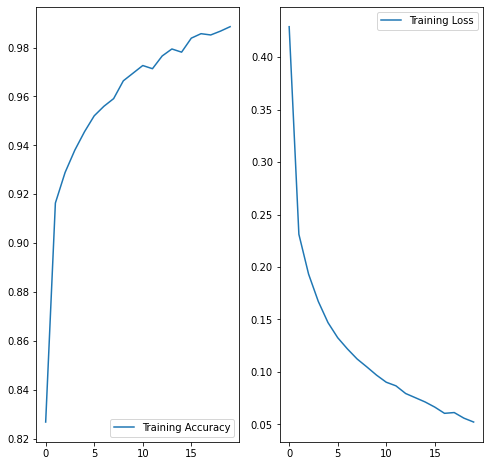

In [23]:

#Plot data - currently only for one cycle

acc_pre = history_pre.history['accuracy']
# val_acc_pre = history_pre.history['val_accuracy']

loss_pre = history_pre.history['loss']
# val_loss_pre = history_pre.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_pre, label='Training Accuracy')
# plt.plot(epochs_range, val_acc_pre, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_pre, label='Training Loss')
# plt.plot(epochs_range, val_loss_pre, label='Validation Loss')
plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Training and Validation Loss')

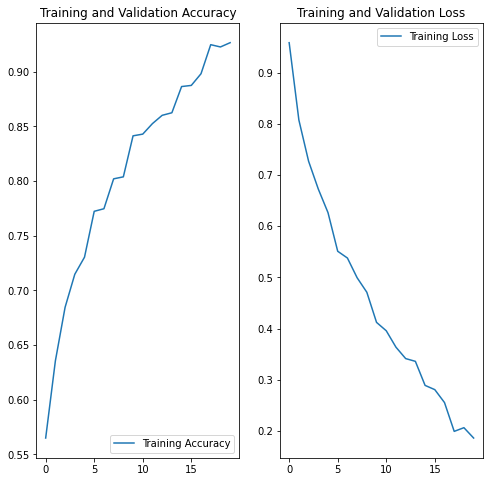

In [24]:
#Plot data - currently only for one cycle


acc = history_scratch.history['accuracy']
# val_acc = history_scratch.history['val_accuracy']

loss = history_scratch.history['loss']
# val_loss = history_scratch.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')